In [1]:
import matplotlib as mpl
mpl.use("pgf")

## TeX preamble
pgf_with_pdflatex = {
    "font.family": "serif",
    "text.usetex": True,
    "text.latex.unicode": True,
    "pgf.texsystem": "pdflatex",
    "pgf.preamble": [
         r"\usepackage[utf8x]{inputenc}",
         r"\usepackage[T1]{fontenc}",
         r"\usepackage[]{libertine}"
         r"\usepackage[libertine]{newtxmath}"
         ]
}
mpl.rcParams.update(pgf_with_pdflatex)

mpl.rcParams['font.family'] = 'Libertine'

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Linux Libertine']})

import matplotlib.font_manager as fm
prop = fm.FontProperties(fname='/usr/local/texlive/2017/texmf-dist/fonts/opentype/public/libertine/LinLibertine_DR.otf')

In [2]:
import numpy as np
from matplotlib import pyplot as plt
plt.rc('text',usetex=True)
plt.rc('figure',figsize=(5.05,3.1),dpi=100)
plt.rc('text.latex',preamble=[r'\usepackage[]{libertine}',r'\usepackage[libertine]{newtxmath}'])
%matplotlib inline

In [3]:
A = 0.1
eps = 0.1
w = 2*np.pi/10

def vel(t,x):
    f = eps*np.sin(w*t)*x.T[0]**2 + (1-2*eps*np.sin(w*t))*x.T[0]
    dfdx = 2*eps*np.sin(w*t)*x.T[0]+ (1-2*eps*np.sin(w*t))
    return np.pi*A*np.array([-np.sin(np.pi*f)*np.cos(np.pi*x.T[1]),np.cos(np.pi*f)*np.sin(np.pi*x.T[1])*dfdx]).T

def jac_vel(t,x):
    f = eps*np.sin(w*t)*x.T[0]**2 + (1-2*eps*np.sin(w*t))*x.T[0]
    dfdx = 2*eps*np.sin(w*t)*x.T[0]+ (1-2*eps*np.sin(w*t))
    d2fdx2 = 2*eps*np.sin(w*t)
    return np.pi*A*np.array([[-np.cos(np.pi*f)*np.pi*dfdx*np.cos(np.pi*x.T[1]),np.sin(np.pi*f)*np.pi*np.sin(np.pi*x.T[1])],
                             [-np.sin(np.pi*f)*np.pi*dfdx*np.sin(np.pi*x.T[1])*dfdx + np.cos(np.pi*f)*np.pi*np.sin(np.pi*x.T[1])*d2fdx2,np.cos(np.pi*f)*np.pi*np.cos(np.pi*x.T[1])*dfdx]]).transpose(3,2,0,1)

In [236]:
xmin,xmax = 0,2
ymin,ymax = 0,1

nx = 1000
ny = 500

x,dx = np.linspace(xmin,xmax,nx,retstep=True)
y,dy = np.linspace(ymin,ymax,ny,retstep=True)

def makegrid(x,y):
    return np.array(np.meshgrid(x,y,indexing='ij')).transpose(1,2,0)

def initialjacobian(x,y):
    q = []
    for k in range(x.size):
        q.append(np.asarray([np.eye(2,dtype=np.float64) for j in range(y.size)]))
    return np.asarray(q)

def get_evals(t0,x,y,tf,h,f):
    g = makegrid(x,y)
    jac = initialjacobian(x,y)
    for j in range(np.ceil((tf-t0)/h).astype(int)):
        k1 = f(t0+j*h,g)
        jv = jac_vel(t0+j*h,g)
        k1_j = np.zeros(jac.shape)
        k2_j = np.zeros(jac.shape)
        #for q in range(2):
        #    for l in range(2):
        #        for k in range(2):
        #            k1_j[:,:,q,l] += jv[:,:,q,k]*jac[:,:,k,l]
        k1_j[:,:,0,0] = jv[:,:,0,0]*jac[:,:,0,0] + jv[:,:,0,1]*jac[:,:,1,0]
        k1_j[:,:,0,1] = jv[:,:,0,0]*jac[:,:,0,1] + jv[:,:,0,1]*jac[:,:,1,1]
        k1_j[:,:,1,0] = jv[:,:,1,0]*jac[:,:,0,0] + jv[:,:,1,1]*jac[:,:,1,0]
        k1_j[:,:,1,1] = jv[:,:,1,0]*jac[:,:,0,1] + jv[:,:,1,1]*jac[:,:,1,1]
        k2 = f(t0+(j+1)*h,g+k1*h)
        jv = jac_vel(t0+(j+1)*h,g+k1*h)
        #for q in range(2):
        #    for l in range(2):
        #        for k in range(2):
        #            k2_j[:,:,q,l] += jv[:,:,q,k]*(jac[:,:,k,l]+h*k1_j[:,:,k,l])
        k2_j[:,:,0,0] = jv[:,:,0,0]*(jac[:,:,0,0]+k1_j[:,:,0,0]*h) + jv[:,:,0,1]*(jac[:,:,1,0]+k1_j[:,:,1,0]*h)
        k2_j[:,:,0,1] = jv[:,:,0,0]*(jac[:,:,0,1]+k1_j[:,:,0,1]*h) + jv[:,:,0,1]*(jac[:,:,1,1]+k1_j[:,:,1,1]*h)
        k2_j[:,:,1,0] = jv[:,:,1,0]*(jac[:,:,0,0]+k1_j[:,:,0,0]*h) + jv[:,:,1,1]*(jac[:,:,1,0]+k1_j[:,:,1,0]*h)
        k2_j[:,:,1,1] = jv[:,:,1,0]*(jac[:,:,0,1]+k1_j[:,:,0,1]*h) + jv[:,:,1,1]*(jac[:,:,1,1]+k1_j[:,:,1,1]*h)
        g = g + (k1+k2)*h/2.
        jac = jac + (k1_j+k2_j)*h/2.
    #u,s,v = np.linalg.svd(jac)
    return jac
    #return g,s**2,v.transpose(0,1,3,2)

def _rk2_advection(t0,x,y,tf,h,f):
    g = makegrid(x,y)
    gr = makegrid(x+0.01,y)
    gl = makegrid(x-0.01,y)
    gu = makegrid(x,y+0.01)
    gd = makegrid(x,y-0.01)
    for j in range(np.ceil((tf-t0)/h).astype(int)):
        k1 = f(t0+j*h,g)
        k2 = f(t0+(j+1)*h,g+k1*h)
        g = g + (k1+k2)*h/2.
        k1 = f(t0+j*h,gr)
        k2 = f(t0+(j+1)*h,gr+k1*h)
        gr = gr + (k1+k2)*h/2.
        k1 = f(t0+j*h,gl)
        k2 = f(t0+(j+1)*h,gl+k1*h)
        gl = gl + (k1+k2)*h/2.
        k1 = f(t0+j*h,gu)
        k2 = f(t0+(j+1)*h,gu+k1*h)
        gu = gu + (k1+k2)*h/2.
        k1 = f(t0+j*h,gd)
        k2 = f(t0+(j+1)*h,gd+k1*h)
        gd = gd + (k1+k2)*h/2.
    return g
    
    

In [233]:
%timeit _rk2_advection(0,x,y,20,0.1,vel)

10.3 s ± 177 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [234]:
%timeit get_evals(0,x,y,20,0.1,vel)

8.13 s ± 228 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [94]:
#gf,vals,vecs = get_evals(0,x,y,20,0.01,vel)
jac = get_evals(0,x,y,20,0.01,vel)


In [22]:
s = np.linalg.svd(jac,compute_uv=False)

In [95]:
u,s,v = np.linalg.svd(jac)

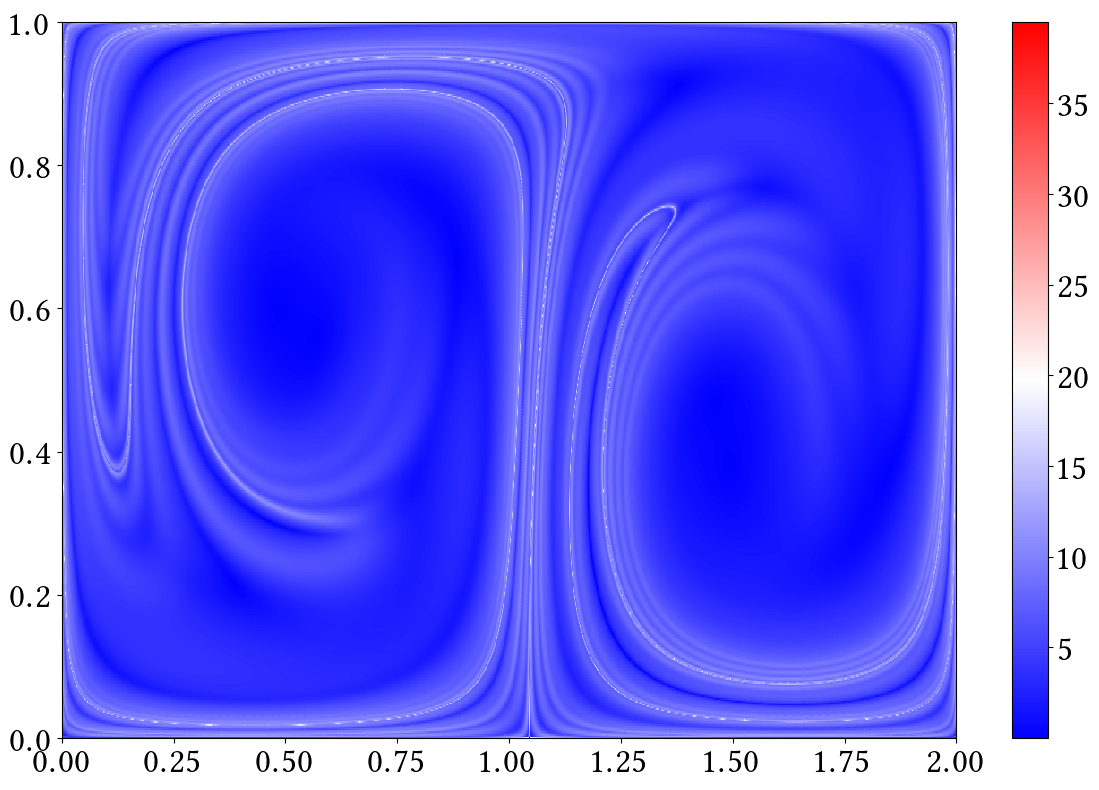

In [245]:
fig = plt.figure(1,figsize=(12,8))
plot = fig.add_subplot(111)
X,Y = np.meshgrid(x,y,indexing='ij')
msh=plot.pcolormesh(X,Y,np.log(s[...,0]**2),cmap='bwr')
bar=plt.colorbar(msh)
plot.tick_params(axis='both', which='major', labelsize=25)
plot.tick_params(axis='both', which='minor', labelsize=10)
bar.ax.tick_params(labelsize=25)
plt.tight_layout()
plt.savefig('/home/arne/Desktop/ftle-variational.png',dpi=350)
#plt.pcolormesh(X[1:-1,1:-1],Y[1:-1,1:-1],np.log(vals[1:-1,1:-1,1]**2+vals[1:-1,1:-1,0]**2),cmap='bwr')

In [12]:
s.shape

(200, 100, 2)

In [379]:
idx = np.greater_equal(np.log(vals[:,:,1]),10)

In [380]:
idx.shape

(200, 100)

In [381]:
bals = np.log(vals[:,:,1])
bals[idx] = 15

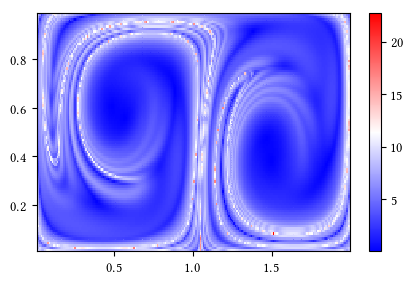

In [386]:
X,Y = np.meshgrid(x,y,indexing='ij')
plt.pcolormesh(X[1:-1,1:-1],Y[1:-1,1:-1],np.log(vals[1:-1,1:-1,1]),cmap='bwr')
plt.colorbar()
#plt.pcolormesh(X[1:-1,1:-1],Y[1:-1,1:-1],np.log(vals[1:-1,1:-1,1]**2+vals[1:-1,1:-1,0]**2),cmap='bwr')

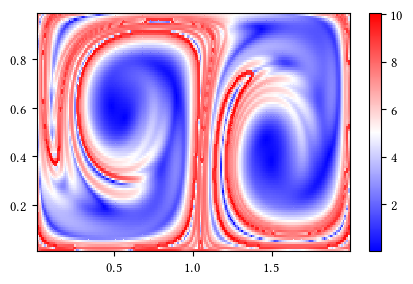

In [361]:
X,Y = np.meshgrid(x,y,indexing='ij')
plt.pcolormesh(X[1:-1,1:-1],Y[1:-1,1:-1],np.log(evals[:,:,1]),cmap='bwr')
plt.colorbar()

In [26]:
v.shape

(400, 200, 2, 2)

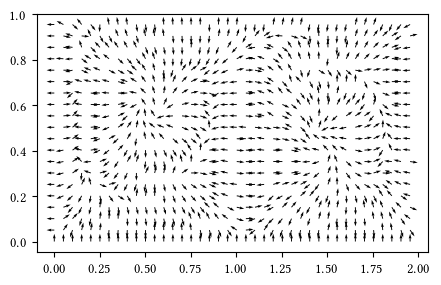

In [44]:
plt.quiver(X[::10,::10],Y[::10,::10],v[::10,::10,0,0],v[::10,::10,0,1])

In [32]:
v = v.transpose(0,1,3,2)

In [34]:
jac[0,0]

array([[  2.67620401e-09,   0.00000000e+00],
       [  0.00000000e+00,   3.73665563e+08]])

In [37]:
u.shape,s.shape,v.shape

((400, 200, 2, 2), (400, 200, 2), (400, 200, 2, 2))

In [38]:
S = np.zeros((*s.shape,2))

In [40]:
S[...,0,0] = s[...,0]
S[...,1,1] = s[...,1]

In [41]:
np.allclose(jac,np.dot(u,S.dot(v)))

MemoryError: 

In [42]:
np.dot(u[0,0],S[0,0].dot(v[0,0]))

array([[  2.67620401e-09,   0.00000000e+00],
       [  0.00000000e+00,   3.73665563e+08]])

In [62]:
def get_hess_lmbd2(s):
    hess = np.empty((*s.shape[:2],2,2))
    lmbd2 = s[...,0]**2
    hess[1:-1,:,0,0] =  (lmbd2[2:]-2*lmbd2[1:-1]+lmbd2[:-2])/dx**2
    hess[0,:,0,0] = (2*lmbd2[0]-5*lmbd2[1]+4*lmbd2[2]-lmbd2[3])/dx**2
    hess[-1,:,0,0] = (2*lmbd2[-1]-5*lmbd2[-2]+4*lmbd2[-3]-lmbd2[-4])/dx**2
    
    hess[:,1:-1,1,1] =  (lmbd2[:,2:]-2*lmbd2[:,1:-1]+lmbd2[:,:-2])/dx**2
    hess[:,0,1,1] = (2*lmbd2[:,0]-5*lmbd2[:,1]+4*lmbd2[:,2]-lmbd2[:,3])/dx**2
    hess[:,-1,1,1] = (2*lmbd2[:,-1]-5*lmbd2[:,-2]+4*lmbd2[:,-3]-lmbd2[:,-4])/dx**2
    
    ddx = np.empty((s.shape[:2]))
    ddy = np.copy(ddx)
    
    ddx[1:-1,:] = (lmbd2[2:]-lmbd2[:-2])/(2*dx)
    ddx[0,:] = (-lmbd2[2]+4*lmbd2[1]-3*lmbd2[0])/(2*dx)
    ddx[-1,:] = (3*lmbd2[-1]-4*lmbd2[-2]+lmbd2[-3])/(2*dx)
    
    ddy[:,1:-1] = (lmbd2[:,2:]-lmbd2[:,:-2])/(2*dy)
    ddy[:,0] = (-lmbd2[:,2]+4*lmbd2[:,1]-3*lmbd2[:,0])/(2*dy)
    ddy[:,-1] = (3*lmbd2[:,-1]-4*lmbd2[:,-2]+lmbd2[:,-3])/(2*dy)
    
    hess[1:-1,:,1,0] = (ddy[2:]-ddy[:-2])/(2*dx)
    hess[0,:,1,0] = (-ddy[2]+4*ddy[1]-3*ddy[0])/(2*dx)
    hess[-1,:,1,0] = (3*ddy[-1]-4*ddy[-2]+ddy[-3])/(2*dx)
    
    hess[:,1:-1,0,1] = (ddx[:,2:]-ddx[:,:-2])/(2*dy)
    hess[:,0,0,1] = (-ddx[:,2]+4*ddx[:,1]-3*ddx[:,0])/(2*dy)
    hess[:,-1,0,1] = (3*ddx[:,-1]-4*ddx[:,-2]+ddx[:,-3])/(2*dy)
    
    return hess
    

In [97]:
h = get_hess_lmbd2(s)

In [56]:
h.shape

(400, 200, 2, 2)

In [61]:
*s.shape

SyntaxError: can't use starred expression here (<ipython-input-61-6f68bec67368>, line 1)

In [71]:
def get_strain_evecs(v):
    xi2 = v[:,:,0]
    xi1 = v[:,:,1]
    
    return xi1,xi2

def get_strain_evals(s):
    lmbd2 = s[...,0]**2
    lmbd1 = s[...,1]**2
    
    return lmbd1,lmbd2

In [98]:
xi1,xi2 = get_strain_evecs(v)

In [99]:
lmbd1,lmbd2 = get_strain_evals(s)

In [67]:
xi1.shape

(400, 200, 2)

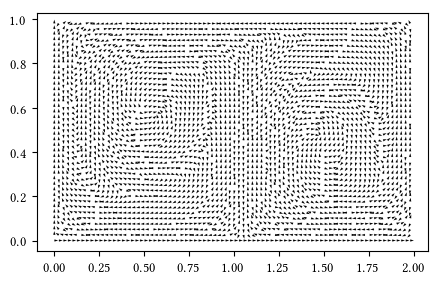

In [69]:
plt.quiver(X[::5,::5],Y[::5,::5],xi1[::5,::5,0],xi1[::5,::5,1])

In [70]:
s.shape

(400, 200, 2)

In [73]:
h.shape

(400, 200, 2, 2)

In [100]:
a_true = np.logical_and(np.less(lmbd1,lmbd2),np.greater(lmbd2,1))

In [101]:
b_true = np.less_equal(np.sum(xi2*np.sum(h*xi2[...,np.newaxis],axis=3),axis=2),0)

In [76]:
h.shape

(400, 200, 2, 2)

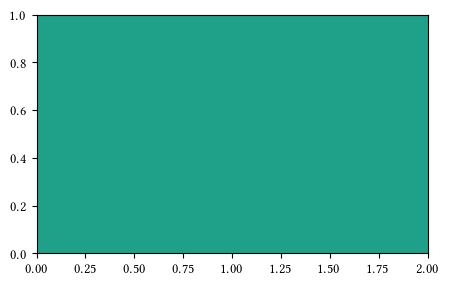

In [78]:
plt.contourf(X,Y,a_true)

In [86]:
b_true.shape

(400, 200)

In [102]:
ab = np.logical_and(a_true,b_true)

In [110]:
cm = mpl.colors.ListedColormap(['white','tomato'])

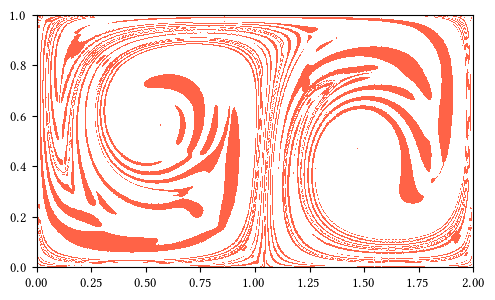

In [112]:
plt.pcolormesh(X,Y,ab,cmap=cm)
plt.tight_layout()
plt.savefig('/home/arne/Desktop/ab_eq_of_vari.png',dpi=350)

In [113]:
num_vert_g0 = 4
num_horz_g0 = 4
def find_g0():
    msk = np.zeros((nx,ny),dtype=np.bool)
    s_horz = np.ceil(nx/(num_horz_g0+1)).astype(int)
    s_vert = np.ceil(ny/(num_vert_g0+1)).astype(int)
    for j in range(1,num_vert_g0+1):
        msk[np.minimum(j*s_horz,nx-1),:] = True
    for j in range(1,num_horz_g0+1):
        msk[:,np.minimum(j*s_vert,ny-1)] = True
        
    return msk

In [114]:
g0msk = find_g0()

In [118]:
g0 = np.array(np.meshgrid(x,y,indexing='ij')).transpose(1,2,0)[np.logical_and(g0msk,ab)]

In [119]:
g0.shape

(1457, 2)

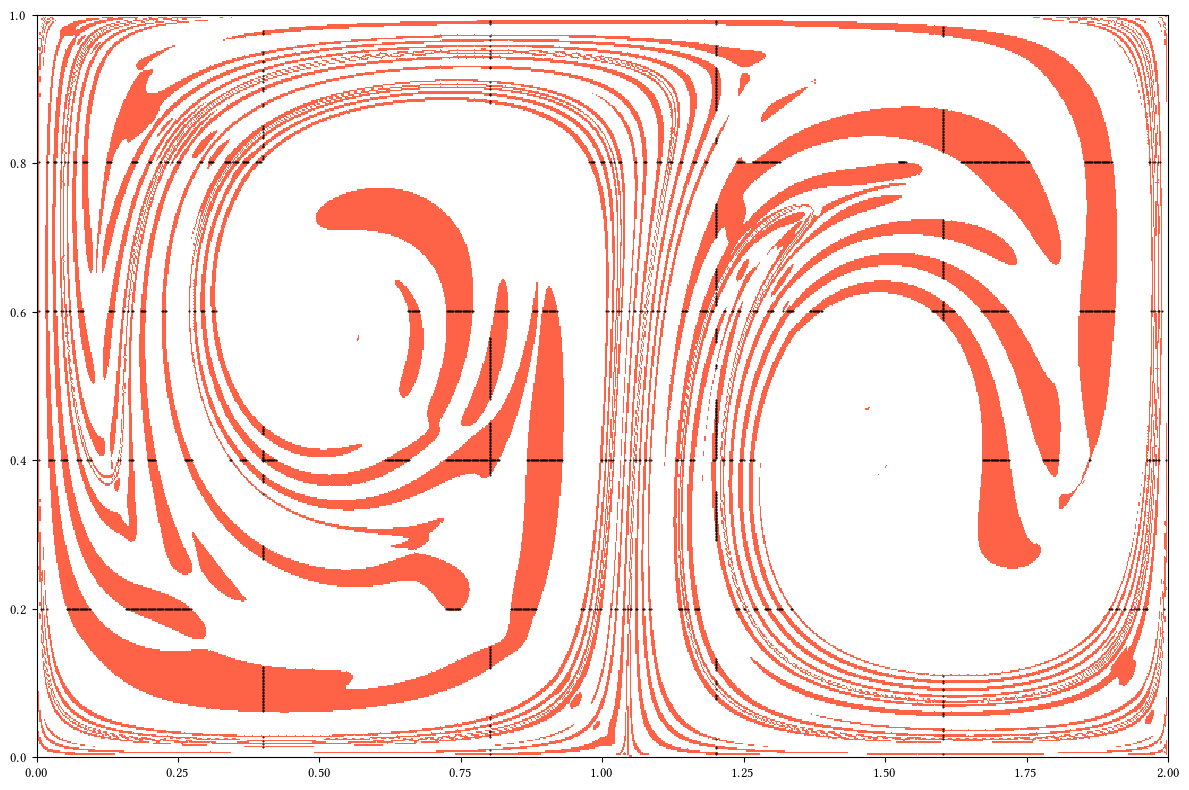

In [124]:
plt.figure(figsize=(12,8))
plt.pcolormesh(X,Y,ab,cmap=cm)
plt.scatter(g0[:,0],g0[:,1],c='k',s=1,marker='.')
plt.tight_layout()
#plt.savefig('/home/arne/Desktop/ab_eq_of_vari.png',dpi=350)

In [169]:
class LinearSpecialDerivative:
    def __init__(self,grid,xi):
        self.grid = grid
        self.dx = self.grid[1,0,0]-self.grid[0,0,0]
        self.dy = self.grid[0,1,1]-self.grid[0,0,1]
        self.xi = xi
        self.prev = None
        #self.reverse = False
    def clear_previous(self):
        self.prev = None
    def set_previous(self,prev):
        self.prev = prev
    #def flip(self):
    #    self.reverse = True
    #def flip_back(self):
    #    self.reverse = False
    def __call__(self,pos):
        
        pos[0] = np.maximum(xmin-self.dx,np.minimum(pos[0],xmax+self.dx))
        pos[1] = np.maximum(ymin-self.dy,np.minimum(pos[1],ymax+self.dy))
        #if pos[0] > x_max + self.dx:
        #    pos[0] = x_max + self.dx
        #elif pos[0] < x_min - self.dx:
        #    pos[0] = x_min - self.dx
        
        #if pos[1] > y_max + self.dy:
        #    pos[1] = y_max + self.dy
        #elif pos[1] < y_min - self.dy:
        #    pos[1] = y_min - self.dy
        
        i = int(np.maximum(0,np.minimum(pos[0]/self.dx,self.grid.shape[0]-2)))
        j = int(np.maximum(0,np.minimum(pos[1]/self.dy,self.grid.shape[1]-2)))

        
        subxi = self.xi[i:i+2,j:j+2]

        # Choose pivot vector and fix directions of others based on this one
        for ii in range(2):
            for jj in range(2):
                if ii == 0 and jj == 0:
                    pass
                else:
                    dp = np.sign(np.dot(subxi[0,0],subxi[ii,jj]))
                    if dp < 0:
                        subxi[ii,jj] = - subxi[ii,jj]
                    #subxi[:,ii,jj] = np.sign(np.dot(subxi[:,0,0],subxi[:,ii,jj])) * subxi[:,ii,jj]
                    
        wr = (pos[0]-i*self.dx)/self.dx
        wl = 1-wr
        wt = (pos[1]-j*self.dy)/self.dy
        wb = 1-wt
        
        xi = wl*(wb*subxi[0,0]+wt*subxi[0,1])+wr*(wb*subxi[1,0]+wt*subxi[1,1])
        # Normalize xi
        xi = xi / np.sqrt(xi[0]**2+xi[1]**2)
        
        if self.prev is None:
            #if not self.reverse:
            sign = 1.
            #else:
            #    sign = -1.
        else:
            sign = -1. if np.sign(np.dot(self.prev,xi)) < 0 else 1.
        return sign*xi
    
class InABDomain:
    def __init__(self,pos_init,lmbd1,lmbd2,hess_lmbd2,xi2,x_min,x_max,y_min,y_max,padding_factor=0.01):
        self._lmbd1_spline = RectBivariateSpline(pos_init[:,0,0],pos_init[0,:,1],lmbd1,bbox=[xmin-(xmax-xmin)*padding_factor,xmax+(xmax-xmin)*padding_factor,ymin-(ymax-ymin)*padding_factor,ymax+(ymax-ymin)*padding_factor],kx=1,ky=1)
        self._lmbd2_spline = RectBivariateSpline(pos_init[:,0,0],pos_init[0,:,1],lmbd2,bbox=[xmin-(xmax-xmin)*padding_factor,xmax+(xmax-xmin)*padding_factor,ymin-(ymax-ymin)*padding_factor,ymax+(ymax-ymin)*padding_factor],kx=1,ky=1)
        self._hess_lmbd2_xx_spline = RectBivariateSpline(pos_init[:,0,0],pos_init[0,:,1],hess_lmbd2[:,:,0,0],bbox=[xmin-(xmax-xmin)*padding_factor,xmax+(xmax-xmin)*padding_factor,ymin-(ymax-ymin)*padding_factor,ymax+(ymax-ymin)*padding_factor],kx=1,ky=1)
        self._hess_lmbd2_xy_spline = RectBivariateSpline(pos_init[:,0,0],pos_init[0,:,1],hess_lmbd2[:,:,0,1],bbox=[xmin-(xmax-xmin)*padding_factor,xmax+(xmax-xmin)*padding_factor,ymin-(ymax-ymin)*padding_factor,ymax+(ymax-ymin)*padding_factor],kx=1,ky=1)
        self._hess_lmbd2_yx_spline = RectBivariateSpline(pos_init[:,0,0],pos_init[0,:,1],hess_lmbd2[:,:,1,0],bbox=[xmin-(xmax-xmin)*padding_factor,xmax+(xmax-xmin)*padding_factor,ymin-(ymax-ymin)*padding_factor,ymax+(ymax-ymin)*padding_factor],kx=1,ky=1)
        self._hess_lmbd2_yy_spline = RectBivariateSpline(pos_init[:,0,0],pos_init[0,:,1],hess_lmbd2[:,:,1,1],bbox=[xmin-(xmax-xmin)*padding_factor,xmax+(xmax-xmin)*padding_factor,ymin-(ymax-ymin)*padding_factor,ymax+(ymax-ymin)*padding_factor],kx=1,ky=1)
        self._xi2_x_spline = RectBivariateSpline(pos_init[:,0,0],pos_init[0,:,1],xi2[:,:,0],bbox=[xmin-(xmax-xmin)*padding_factor,xmax+(xmax-xmin)*padding_factor,ymin-(ymax-ymin)*padding_factor,ymax+(ymax-ymin)*padding_factor],kx=1,ky=1)
        self._xi2_y_spline = RectBivariateSpline(pos_init[:,0,0],pos_init[0,:,1],xi2[:,:,1],bbox=[xmin-(xmax-xmin)*padding_factor,xmax+(xmax-xmin)*padding_factor,ymin-(ymax-ymin)*padding_factor,ymax+(ymax-ymin)*padding_factor],kx=1,ky=1)
        
    def __call__(self,pos):
        lmbd1 = self._lmbd1_spline.ev(pos[0],pos[1])
        lmbd2 = self._lmbd2_spline.ev(pos[0],pos[1])
        hess = np.array([[self._hess_lmbd2_xx_spline.ev(pos[0],pos[1]),self._hess_lmbd2_xy_spline.ev(pos[0],pos[1])],[self._hess_lmbd2_yx_spline.ev(pos[0],pos[1]),self._hess_lmbd2_yy_spline.ev(pos[0],pos[1])]])
        xi2 = np.array([self._xi2_x_spline.ev(pos[0],pos[1]),self._xi2_y_spline.ev(pos[0],pos[1])])
        #xi2 = xi2/np.sqrt(xi2[0]**2+xi2[1]**2)
        return ((lmbd1 != lmbd2) and (lmbd2 > 1) and np.less_equal(np.dot(xi2,np.dot(hess,xi2)),0))

class InNumericalDomain:
    def __init__(self,x_min,x_max,y_min,y_max,nx,ny):
        dx = (x_max-x_min)/(nx-1)
        dy = (y_max-y_min)/(ny-1)
        self._x_min = x_min-dx
        self._x_max = x_max+dx
        self._y_min = y_min-dy
        self._y_max = y_max+dx
    
    def __call__(self,pos):
        return pos[0] >= self._x_min and pos[0] <= self._x_max and pos[1] >= self._y_min and pos[1] <= self._y_max
    
class Alpha:
    def __init__(self,lmbd1_spline,lmbd2_spline):
        self.lmbd1_spline = lmbd1_spline
        self.lmbd2_spline = lmbd2_spline
    def __call__(self,pos):
        lmbd1 = self.lmbd1_spline.ev(pos[0],pos[1])
        lmbd2 = self.lmbd2_spline.ev(pos[0],pos[1])
        return ((lmbd2-lmbd1)/(lmbd2+lmbd1))**2

In [170]:


class Strainline:
    def __init__(self,startpoint,l_min,l_f_max,lmbd2_spline):
        self.pos = np.array([startpoint]).reshape((2,1))
        self.l_min = l_min
        self.lmbd2_spline = lmbd2_spline
        self.stationary = np.zeros(2,dtype=np.bool)
        self.cont_failure = np.zeros(2,dtype=np.bool)
        self.outs_dom = np.zeros(2,dtype=np.bool)
        self.max_iter = np.zeros(2,dtype=np.bool)
        self.startpoint_index = 0
        self.tailcut_start = 0
        self.tailcut_end = 0
    def long_enough(self):
        return self.len >= self.l_min
    def append(self,pos):
        self.pos = np.hstack((self.pos,pos.reshape((2,1))))
    def traj(self):
        return self.pos
    def avg_lmbd2(self):
        return np.mean(self.lmbd2_spline.ev(self.pos[1],self.pos[0]))
    def lngth(self):
        return np.sum(np.sqrt((np.diff(self.pos,axis=1)**2).sum(axis=0)))
    def tailcut_traj(self):
        return self.pos[:,self.tailcut_start:self.tailcut_end]
    def tailcut_avg_lmbd2(self):
        return np.mean(self.lmbd2_spline.ev(self.tailcut_traj()[1],self.tailcut_traj()[0]))
    def tailcut_lngth(self):
        return np.sum(np.sqrt((np.diff(self.tailcut_traj(),axis=1)**2).sum(axis=0)))



In [171]:


def RK4_iterator(pos_prev,stride,rhs):
    pos_new = np.zeros(2)
    lk = np.zeros((2,5))
    lk[:,1] = rhs(pos_prev)
    lk[:,2] = rhs(pos_prev+lk[:,1]*stride/2.)
    lk[:,3] = rhs(pos_prev+lk[:,2]*stride/2.)
    lk[:,4] = rhs(pos_prev+lk[:,3]*stride)
    lk[:,0] = (lk[:,1]+2*lk[:,2]+2*lk[:,3]+lk[:,4])/6.
    pos_new[0] = pos_prev[0]+lk[0,0]*stride
    pos_new[1] = pos_prev[1]+lk[1,0]*stride
    return pos_new



In [198]:
def iteratestrainline(startpoint,max_iter,rhs_f,rhs_b,stride,l_f_max,l_min,alpha,tol_alpha,in_ab,in_domain,lmbd2_spline):
    strainline_f = Strainline(startpoint,l_min,l_f_max,lmbd2_spline)
    counter = 0
    l_f = 0.
    rhs_f.clear_previous()
    rhs_f.set_previous(rhs_f(strainline_f.pos[:,-1]))
    
    rhs_b.clear_previous()
    rhs_b.set_previous(-rhs_f.prev)
    
    
    tailcut_index = 0
    
    pos_trial = RK4_iterator(strainline_f.pos[:,-1],stride,rhs_f)
    while l_f<l_f_max and alpha(pos_trial)>tol_alpha and in_domain(pos_trial) and counter<max_iter:
        if not in_ab(pos_trial):
            l_f += np.sqrt((pos_trial[0]-strainline_f.pos[0,-1])**2+(pos_trial[1]-strainline_f.pos[1,-1])**2)
        else:
            l_f = 0.
            tailcut_index = np.shape(strainline_f.pos)[1]
        strainline_f.append(pos_trial)
        rhs_f.set_previous(rhs_f(strainline_f.pos[:,-2]))
        counter+=1
        pos_trial = RK4_iterator(strainline_f.pos[:,-1],stride,rhs_f)

    if alpha(strainline_f.pos[:,-1])<=tol_alpha:
        strainline_f.stationary[1] = True
    if not in_domain(pos_trial):
        strainline_f.outs_dom[1] = True
    if counter == max_iter:
        strainline_f.max_iter[1] = True
    if l_f>=l_f_max:
        strainline_f.cont_failure[1] = True
        strainline_f.tailcut_end = tailcut_index
    else:
        strainline_f.tailcut_end = strainline_f.pos.shape[1]-1

        
        
    strainline_b = Strainline(startpoint,l_min,l_f_max,lmbd2_spline)
    counter = 0
    l_f = 0.
    L = 0.
    tailcut_index = 0
    
    pos_trial = RK4_iterator(strainline_b.pos[:,-1],stride,rhs_b)
    while l_f<l_f_max and alpha(pos_trial)>tol_alpha and in_domain(pos_trial) and counter<max_iter:
        if not in_ab(pos_trial):
            l_f += np.sqrt((pos_trial[0]-strainline_b.pos[0,-1])**2+(pos_trial[1]-strainline_b.pos[1,-1])**2)
        else:
            l_f = 0.
            tailcut_index = np.shape(strainline_b.pos)[1]
        strainline_b.append(pos_trial)
        rhs_b.set_previous(rhs_b(strainline_b.pos[:,-2]))
        counter+=1
        pos_trial = RK4_iterator(strainline_b.pos[:,-1],stride,rhs_b)
    
    
    if alpha(strainline_b.pos[:,-1])<=tol_alpha:
        strainline_b.stationary[0] = True
    if not in_domain(pos_trial):
        strainline_b.outs_dom[0] = True
    if counter == max_iter:
        strainline_b.max_iter[0] = True
    if l_f>=l_f_max:
        strainline_b.cont_failure[0] = True
        strainline_b.tailcut_start = strainline_b.pos.shape[1]-tailcut_index
    else:
        strainline_b.tailcut_start = 0
        
    
    strainline_b.len = np.sum(np.sqrt((np.diff(strainline_b.pos,axis=1)**2).sum(axis=0)))
    
   
    
    strainline_b.startpoint_index = strainline_b.pos.shape[1]-1
    strainline_b.pos = np.hstack((strainline_b.pos[:,::-1],strainline_f.pos[:,1:]))
    strainline_b.stationary[1] = strainline_f.stationary[1]
    strainline_b.cont_failure[1] = strainline_f.cont_failure[1]
    strainline_b.outs_dom[1] = strainline_f.outs_dom[1]
    strainline_b.max_iter[1] = strainline_f.max_iter[1]
    strainline_b.tailcut_end = strainline_b.startpoint_index + strainline_f.tailcut_end - 1
    
    return strainline_b

def computestrainlines(dompts,max_iter,rhs_f,rhs_b,stride,l_f_max,l_min,alpha,tol_alpha,in_ab,in_domain,lmbd2_spline,pn,q):
    strainlines = []
    for j in range(dompts.shape[0]):
        strainlines.append(iteratestrainline(dompts[j],max_iter,rhs_f,rhs_b,stride,l_f_max,l_min,alpha,tol_alpha,in_ab,in_domain,lmbd2_spline))
        if not (np.mod(j +  1 +  np.floor(np.size(dompts,0)/4).astype(int), np.floor(np.size(dompts,0)/4).astype(int))):
            print('Process {}: Finished integrating strainline candidate {} of {}'.format(pn,j+1,np.size(dompts,0)))
    q.put(strainlines)


In [201]:


def develop_strainlines(max_iter,stride,l_f_max,l_min,tol_alpha,padding_factor=0.01,n_proc=4):
    strainlines = []

    in_AB_domain = InABDomain(pos,lmbd1,lmbd2,h,xi2,xmin,xmax,ymin,ymax,padding_factor)
    in_numerical_domain = InNumericalDomain(xmin,xmax,ymin,ymax,nx,ny)

    lmbd1_spline = RectBivariateSpline(pos[:,0,0],pos[0,:,1],lmbd1,bbox=[xmin-(xmax-xmin)*padding_factor,xmax+(xmax-xmin)*padding_factor,ymin-(ymax-ymin)*padding_factor,ymax+(ymax-ymin)*padding_factor],kx=1,ky=1)
    lmbd2_spline = RectBivariateSpline(pos[:,0,0],pos[0,:,1],lmbd2,bbox=[xmin-(xmax-xmin)*padding_factor,xmax+(xmax-xmin)*padding_factor,ymin-(ymax-ymin)*padding_factor,ymax+(ymax-ymin)*padding_factor],kx=1,ky=1)

    rhs_f = LinearSpecialDerivative(pos,xi1)
    rhs_b = LinearSpecialDerivative(pos,xi1)
    alpha = Alpha(lmbd1_spline,lmbd2_spline)   

    div = np.floor(np.linspace(0,g0.shape[0],n_proc+1)).astype(int)
    
    qlist = [mp.Queue() for j in range(n_proc)]
    plist = [mp.Process(target=computestrainlines,
                       args = (g0[div[j]:div[j+1]],
                              max_iter,rhs_f,rhs_b,stride,l_f_max,l_min,alpha,tol_alpha,in_AB_domain,in_numerical_domain,lmbd2_spline,j,qlist[j])) 
             for j in range(n_proc)]
    tic = time.time()
    for p in plist:
        p.start()
    for q in qlist:
        strainlines = strainlines + q.get()
    for p in plist:
        p.join()
    mins, secs = np.divmod(time.time()-tic,60)
    print('Strainline iteration finished in {} minutes and {} seconds'.format(mins,secs))
    return strainlines



In [202]:
max_iter = 10000
stride = 0.001
l_f_max = 0.2
l_min = 1.
tol_alpha = 1.e-6

#try:
#    if integrator.__name__ in fixed_step_integrators:
#        strainlines = np.load('precomputed_strainlines/{}/strainlines_h={}_max_iter={}_stride={}_l_f_max={}_l_min={}_tol_alpha={}.npy'.format(integrator.__name__,h,max_iter,stride,l_f_max,l_min,tol_alpha))
#    else:
#        strainlines = np.load('precomputed_strainlines/{}/strainlines_atoL={}_rtol={}_max_iter={}_stride={}_l_f_max={}_l_min={}_tol_alpha={}.npy'.format(integrator.__name__,atol,rtol,max_iter,stride,l_f_max,l_min,tol_alpha))
#except IOError:
#    print('Strainline config not loaded!')
strainlines = develop_strainlines(max_iter,stride,l_f_max,l_min,tol_alpha)

Process 3: Finished integrating strainline candidate 91 of 365
Process 0: Finished integrating strainline candidate 91 of 364
Process 1: Finished integrating strainline candidate 91 of 364
Process 2: Finished integrating strainline candidate 91 of 364
Process 2: Finished integrating strainline candidate 182 of 364
Process 3: Finished integrating strainline candidate 182 of 365
Process 0: Finished integrating strainline candidate 182 of 364
Process 1: Finished integrating strainline candidate 182 of 364
Process 2: Finished integrating strainline candidate 273 of 364
Process 3: Finished integrating strainline candidate 273 of 365
Process 0: Finished integrating strainline candidate 273 of 364
Process 1: Finished integrating strainline candidate 273 of 364
Process 2: Finished integrating strainline candidate 364 of 364
Process 0: Finished integrating strainline candidate 364 of 364
Process 3: Finished integrating strainline candidate 364 of 365
Process 1: Finished integrating strainline c

In [203]:
def find_intersections(strainlines,x_min,x_max,y_min,y_max,num_horz,num_vert,vert_x,horz_y):
    n_strainlines = len(strainlines)
    isect_horz = [[[[],[]] for i in range(num_horz)] for j in range(n_strainlines)]
    isect_vert = [[[[],[]] for i in range(num_vert)] for j in range(n_strainlines)]
    tic = time.time()
    for i in range(n_strainlines):
        #traj = strainlines[i].traj()
        traj = strainlines[i].tailcut_traj()
        for j in range(num_horz):
            for k in range(np.size(traj,1)-1):
                if (traj[1,k]-horz_y[j])*(traj[1,k+1]-horz_y[j])<=0:
                    wk = (traj[1,k+1]-horz_y[j])/(traj[1,k+1]-traj[1,k])
                    isect_horz[i][j][0].append(wk*traj[0,k]+(1-wk)*traj[0,k+1])
                    isect_horz[i][j][1].append(horz_y[j])
        for j in range(num_vert):
            for k in range(np.size(traj,1)-1):
                if (traj[0,k]-vert_x[j])*(traj[0,k+1]-vert_x[j])<=0:
                    wk = (traj[0,k+1]-vert_x[j])/(traj[0,k+1]-traj[0,k])
                    isect_vert[i][j][0].append(vert_x[j])
                    isect_vert[i][j][1].append(wk*traj[1,k]+(1-wk)*traj[1,k+1]) 
    mins,secs = np.divmod(time.time()-tic,60)
    print('Intersections found in {} minutes and {} seconds'.format(mins,secs))
    return isect_horz,isect_vert

In [204]:
def find_neighbors(n_strainlines,num_horz,num_vert,intersections_horz,intersections_vert,l_n,n_proc=4):
    div = np.floor(np.linspace(0,n_strainlines,n_proc+1)).astype(int)
    queues = [mp.Queue() for j in range(n_proc)]
    processes = [mp.Process(target=_find_neighbors,
                           args=(n_strainlines,num_horz,num_vert,intersections_horz,intersections_vert,
                                l_n,div[j],div[j+1],j,queues[j]))
                for j in range(n_proc)]
    nbrs_vert = []
    nbrs_horz = []
    tic = time.time()
    for process in processes:
        process.start()
    for q in queues:
        nbrs_vert += q.get()
        nbrs_horz += q.get()
    for process in processes:
        process.join()
    mins,secs = np.divmod(time.time()-tic,60)
    print('Neighbors found in {} minutes and {} seconds'.format(mins,secs))
    return nbrs_vert,nbrs_horz

def _find_neighbors(n_strainlines,num_horz,num_vert,intersections_horz,intersections_vert,l_n,n0,nend,pn,q):
    #n_strainlines = len(strainlines)
    nbrs_vert = []
    nbrs_horz = []
    for i in range(n0,nend):
        nbrs_strline_vert = []
        for j in range(num_vert):
            nbrs_vert_isect = [[] for k in range(len(intersections_vert[i][j][0]))]
            for k in range(n_strainlines):
                for m in range(len(intersections_vert[i][j][0])):
                    for n in range(len(intersections_vert[k][j][0])):
                        if k!=i and np.abs(intersections_vert[i][j][1][m]-intersections_vert[k][j][1][n]) < l_n:
                            nbrs_vert_isect[m].append(k)
                #for m in range(np.minimum(np.size(intersections_vert[i][j][0]),np.size(intersections_vert[k][j][0]))):
                #    if k != i and np.abs(intersections_vert[i][j][1][m]-intersections_vert[k][j][1][m]) < l_n:
                #        nbrs_vert_isect[m].append(k)
            nbrs_strline_vert.append(nbrs_vert_isect)
        nbrs_vert.append(nbrs_strline_vert)
        
        nbrs_strline_horz = []
        for j in range(num_horz):
            nbrs_horz_isect = [[] for k in range(len(intersections_horz[i][j][0]))]
            for k in range(n_strainlines):
                for m in range(len(intersections_horz[i][j][0])):
                    for n in range(len(intersections_horz[k][j][0])):
                        if k!=i and np.abs(intersections_horz[i][j][0][m]-intersections_horz[k][j][0][n]) < l_n:
                            nbrs_horz_isect[m].append(k)
                #for m in range(np.minimum(np.size(intersections_horz[i][j][0]),np.size(intersections_horz[k][j][0]))):
                #    if k != i and np.abs(intersections_horz[i][j][0][m]-intersections_horz[k][j][0][m]) < l_n:
                #        nbrs_horz_isect[m].append(k)
            nbrs_strline_horz.append(nbrs_horz_isect)
        nbrs_horz.append(nbrs_strline_horz)
        if not np.mod(i+1-n0,np.floor((nend-n0)/4).astype(int)):
            print('Process {}: Found neighbors for {} of {} strainlines'.format(pn,i+1-n0,nend-n0))
    q.put(nbrs_vert)
    q.put(nbrs_horz)

In [207]:
def findLCSs(strainlines,nbrs_horz,nbrs_vert,num_horz,num_vert):
    LCSindxs = []
    #progressbar = FloatProgress(min=0,max=len(strainlines))
    #display(progressbar)
    #lmbd2_avgs = [strainline.tailcut_avg_lmbd2() for strainline in strainlines]
    lmbd2_avgs = [strainline.avg_lmbd2() for strainline in strainlines]
    #lngths = [strainline.tailcut_lngth() for strainline in strainlines]
    lngths = [strainline.lngth() for strainline in strainlines]
    for i, (strainline,lmbd2_avg,lngth) in enumerate(zip(strainlines,lmbd2_avgs,lngths)):
        #if not np.mod(i+1,10):
        #    progressbar.value+=10
        for j in range(num_vert):
            for k in range(len(nbrs_vert[i][j])):
                nbr_indxs = set(nbrs_vert[i][j][k])
                T = [lmbd2_avgs[q] for q in nbr_indxs]
                if np.size(T) > 0 and lmbd2_avg >= np.amax(T) and lngth >= strainline.l_min:
                    LCSindxs.append(i)
                    
        for j in range(num_horz):
            for k in range(len(nbrs_horz[i][j])):
                nbr_indxs = set(nbrs_horz[i][j][k])
                T = [lmbd2_avgs[q] for q in nbr_indxs]
                #if (np.size(T) > 0 and lmbd2_avg >= np.amax(T) and strainline.long_enough()):
                if np.size(T) > 0 and lmbd2_avg >= np.amax(T) and lngth >= strainline.l_min:
                    LCSindxs.append(i)
    LCSindxs = list(set(LCSindxs))
    LCSs = []
    for ind in LCSindxs:
        LCSs.append(strainlines[ind])
        print('Strainline {} is an LCS!'.format(ind))
    return LCSs

In [218]:
num_vert_comp = 2
num_horz_comp = 2

vert_x = np.array([0.15,0.15])
horz_y = np.array([0.05,0.05])



l_n = 0.2

isect_horz,isect_vert = find_intersections(strainlines,xmin,xmax,ymin,ymax,num_horz_comp,num_vert_comp,vert_x,horz_y)
nbrs_vert,nbrs_horz = find_neighbors(len(strainlines),num_horz_comp,num_vert_comp,isect_horz,isect_vert,l_n)
LCSs = findLCSs(strainlines,nbrs_horz,nbrs_vert,num_horz_comp,num_vert_comp)

Intersections found in 0.0 minutes and 6.738116979598999 seconds
Process 3: Found neighbors for 91 of 365 strainlines
Process 1: Found neighbors for 91 of 364 strainlines
Process 2: Found neighbors for 91 of 364 strainlines
Process 3: Found neighbors for 182 of 365 strainlines
Process 0: Found neighbors for 91 of 364 strainlines
Process 1: Found neighbors for 182 of 364 strainlines
Process 2: Found neighbors for 182 of 364 strainlines
Process 3: Found neighbors for 273 of 365 strainlines
Process 1: Found neighbors for 273 of 364 strainlines
Process 2: Found neighbors for 273 of 364 strainlines
Process 3: Found neighbors for 364 of 365 strainlines
Process 2: Found neighbors for 364 of 364 strainlines
Process 1: Found neighbors for 364 of 364 strainlines
Process 0: Found neighbors for 182 of 364 strainlines
Process 0: Found neighbors for 273 of 364 strainlines
Process 0: Found neighbors for 364 of 364 strainlines
Neighbors found in 0.0 minutes and 4.015664577484131 seconds
Strainline 931

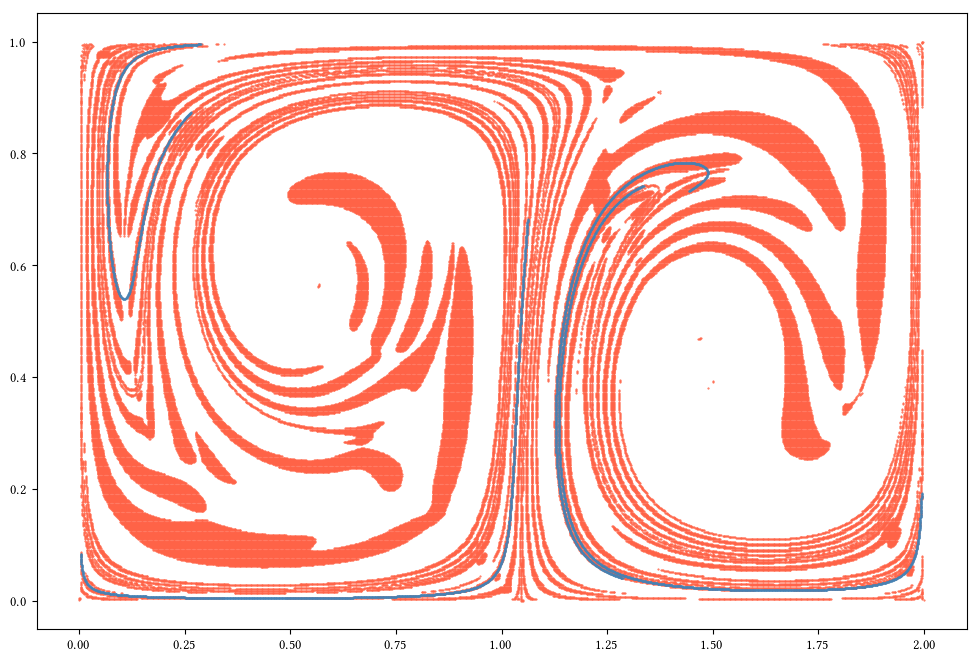

In [219]:
plt.figure(figsize=(12,8))
plt.scatter(pos[ab,0],pos[ab,1],c='tomato',s=1,marker='.')
for qw in LCSs:
    plt.scatter(qw.tailcut_traj()[0],qw.tailcut_traj()[1],c='steelblue',s=1,marker='.')
    
#plt.scatter(grid[0,mask_ab],grid[1,mask_ab],c='tomato',s=1,marker='.')
#for LCS in LCSs:
#    plt.scatter(LCS.tailcut_traj()[0],LCS.tailcut_traj()[1],c='steelblue',s=1,marker='.')

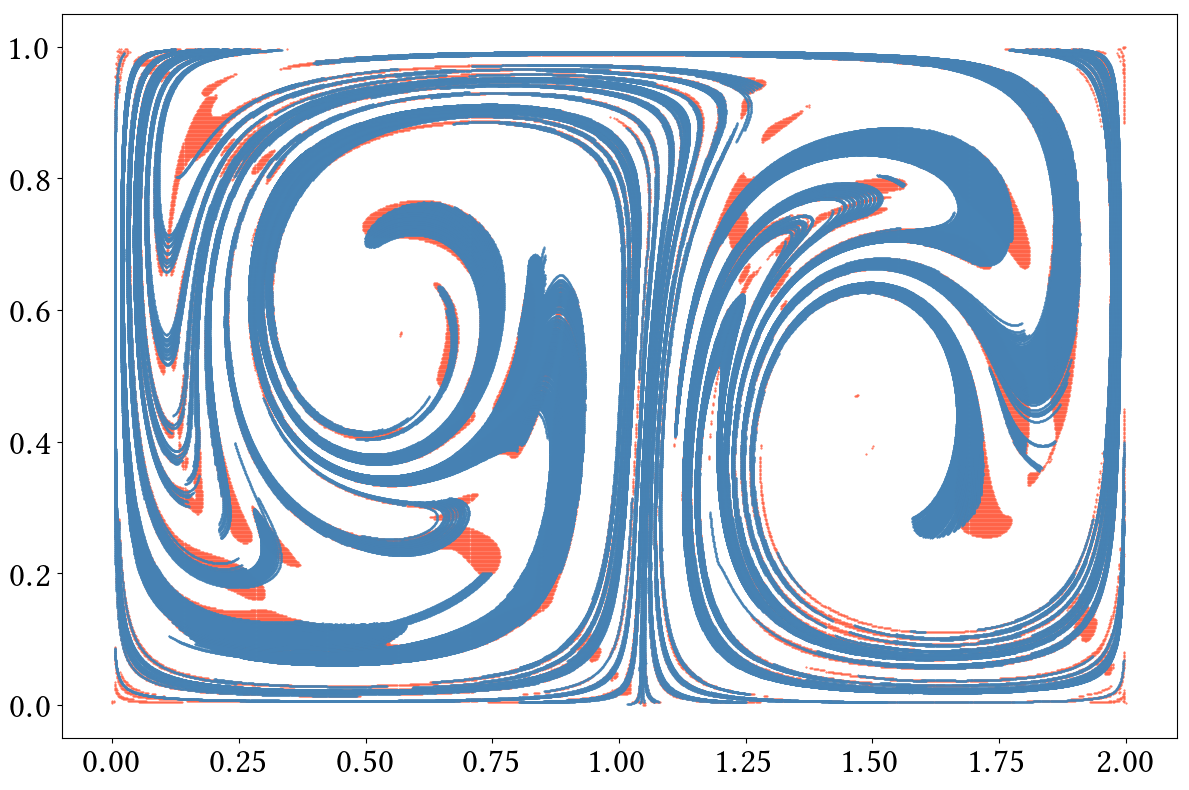

In [226]:


fig = plt.figure(1,figsize=(12,8))
plot = fig.add_subplot(111)

#plt.figure(figsize=(12,8))
plot.scatter(pos[ab,0],pos[ab,1],c='tomato',s=1,marker='.')
for qw in strainlines: 
    plot.scatter(qw.tailcut_traj()[0],qw.tailcut_traj()[1],c='steelblue',s=1,marker='.')
plot.tick_params(axis='both', which='major', labelsize=25)
plot.tick_params(axis='both', which='minor', labelsize=10)
plt.tight_layout()
plt.savefig('/home/arne/Desktop/strainlines_eq_of_vari.png',dpi=350)

In [194]:
strainlines

In [178]:
import multiprocessing as mp
import time

In [125]:
h.shape

(1000, 500, 2, 2)

In [126]:
lmbd2.shape

(1000, 500)

In [127]:
from scipy.interpolate import RectBivariateSpline

In [128]:
X.shape

(1000, 500)

In [158]:
l2s = RectBivariateSpline(x,y,lmbd2,kx=1,ky=1,bbox=[xmin-dx,xmax+dx,ymin-dy,ymax+dy])

In [142]:
l2s.ev(0.2,0.5)

array(326.7683731460602)

In [143]:
dy

0.002004008016032064

In [144]:
0.2/dx

99.900000000000006

In [145]:
0.5/dy

249.50000000000003

In [149]:
lmbd2[100,249]

319.44231030828337

In [150]:
X[100,249]

0.20020020020020018

In [151]:
Y[100,249]

0.49899799599198391

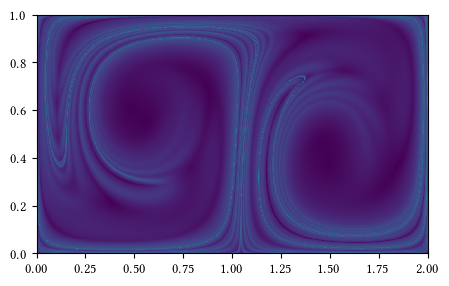

In [153]:
plt.pcolormesh(X,Y,np.log(lmbd2))

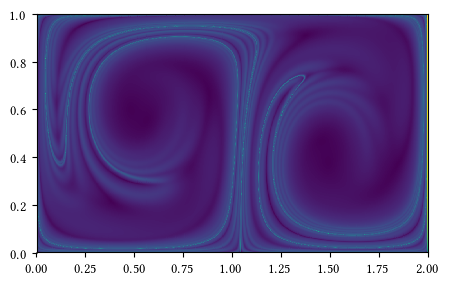

In [159]:
plt.pcolormesh(X+dx/2,Y+dy/2,np.log(l2s.ev(X+dx/2,Y+dy/2)))

In [165]:
pos = np.array(np.meshgrid(x,y,indexing='ij')).transpose(1,2,0)

In [166]:
pos[1,0,0]-pos[0,0,0]

0.002002002002002002

In [167]:
pos[0,1,1]-pos[0,0,1]

0.002004008016032064

In [168]:
pos[:,0,0]

array([ 0.        ,  0.002002  ,  0.004004  ,  0.00600601,  0.00800801,
        0.01001001,  0.01201201,  0.01401401,  0.01601602,  0.01801802,
        0.02002002,  0.02202202,  0.02402402,  0.02602603,  0.02802803,
        0.03003003,  0.03203203,  0.03403403,  0.03603604,  0.03803804,
        0.04004004,  0.04204204,  0.04404404,  0.04604605,  0.04804805,
        0.05005005,  0.05205205,  0.05405405,  0.05605606,  0.05805806,
        0.06006006,  0.06206206,  0.06406406,  0.06606607,  0.06806807,
        0.07007007,  0.07207207,  0.07407407,  0.07607608,  0.07807808,
        0.08008008,  0.08208208,  0.08408408,  0.08608609,  0.08808809,
        0.09009009,  0.09209209,  0.09409409,  0.0960961 ,  0.0980981 ,
        0.1001001 ,  0.1021021 ,  0.1041041 ,  0.10610611,  0.10810811,
        0.11011011,  0.11211211,  0.11411411,  0.11611612,  0.11811812,
        0.12012012,  0.12212212,  0.12412412,  0.12612613,  0.12812813,
        0.13013013,  0.13213213,  0.13413413,  0.13613614,  0.13

In [184]:
g0[20:30].shape

(10, 2)